## 7324 Assignment A4 : Logistic Regression vs SVM
##### Name: Thang Nguyen
##### SMU ID: 48689334

## Imports

In [39]:
# The Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
# Data Wrangling Tool
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Foundational libraries
import pandas as pd
import numpy as np

## Utility Functions

## Loading Dataset

In [40]:
titanic_df = pd.read_csv("../data/titanic.csv")
# check for nulls 
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   name      1309 non-null   object 
 3   sex       1309 non-null   object 
 4   age       1046 non-null   float64
 5   sibsp     1309 non-null   float64
 6   parch     1309 non-null   float64
 7   ticket    1309 non-null   object 
 8   fare      1308 non-null   float64
 9   cabin     295 non-null    object 
 10  embarked  1307 non-null   object 
dtypes: float64(6), object(5)
memory usage: 112.7+ KB


In [41]:
# short preview for later scaling
titanic_df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
0,1.0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S
1,1.0,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S
2,1.0,0.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S
3,1.0,0.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S
4,1.0,0.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S


array([[<AxesSubplot: title={'center': 'pclass'}>,
        <AxesSubplot: title={'center': 'survived'}>],
       [<AxesSubplot: title={'center': 'age'}>,
        <AxesSubplot: title={'center': 'sibsp'}>],
       [<AxesSubplot: title={'center': 'parch'}>,
        <AxesSubplot: title={'center': 'fare'}>]], dtype=object)

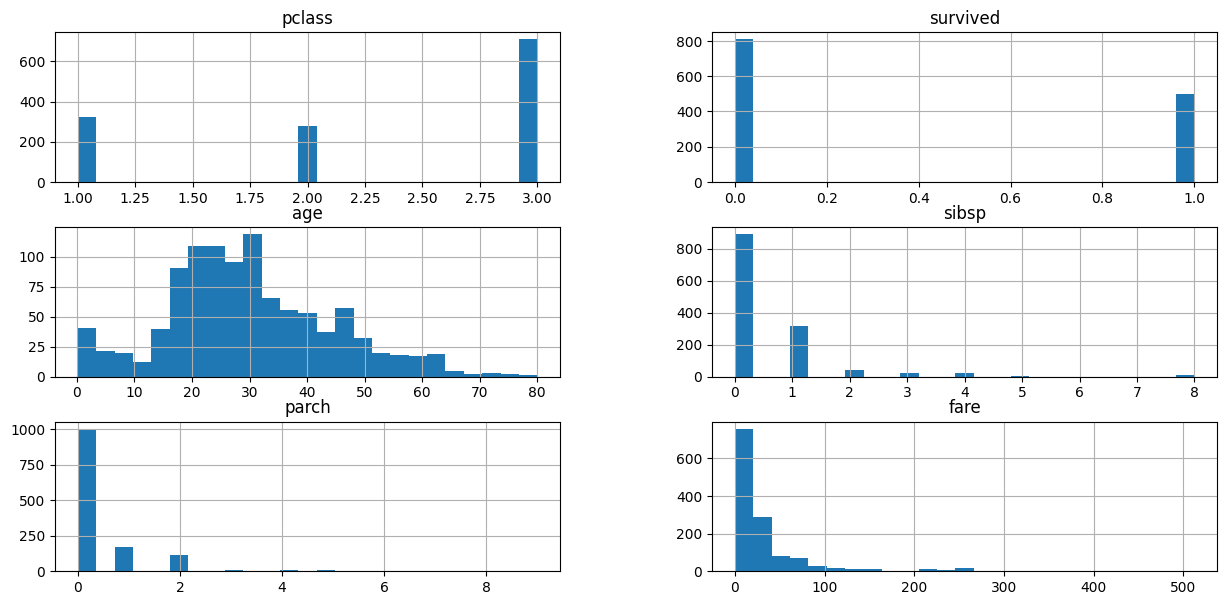

In [42]:
titanic_df.hist(bins=25, figsize=(15,7))

## Cleaning Dataset

### Removing features

#### Remove Cabin
##### Data in this column seemed to include two categories in one in terms of Cabin Number
##### and there appeared to be no way of decomposing these rows

In [43]:
titanic_df.drop('cabin', axis=1, inplace=True)

#### Remove Name
##### Names are unique and may create incorrect correlation

In [44]:
titanic_df.drop('name', axis=1, inplace=True)

#### Remove Ticket
##### Ticket numbers unique and may create incorrect correlation

In [45]:
titanic_df.drop('ticket', axis=1, inplace=True)

In [46]:
titanic_df.head()

,pclass,survived,sex,age,sibsp,parch,fare,embarked
0,1.0,1.0,female,29.0000,0.0,0.0,211.3375,S
1,1.0,1.0,male,0.9167,1.0,2.0,151.5500,S
2,1.0,0.0,female,2.0000,1.0,2.0,151.5500,S
3,1.0,0.0,male,30.0000,1.0,2.0,151.5500,S
4,1.0,0.0,female,25.0000,1.0,2.0,151.5500,S


In [47]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    1309 non-null   float64
 1   survived  1309 non-null   float64
 2   sex       1309 non-null   object 
 3   age       1046 non-null   float64
 4   sibsp     1309 non-null   float64
 5   parch     1309 non-null   float64
 6   fare      1308 non-null   float64
 7   embarked  1307 non-null   object 
dtypes: float64(6), object(2)
memory usage: 82.0+ KB


### Fill NAs

#### Age has a lot of NAs so we fill them with the average age

In [48]:
titanic_df['age'].fillna(titanic_df['age'].mean().round(), inplace=True)

#### Embarked has some NAs so we fill them with the most common port

<AxesSubplot: >

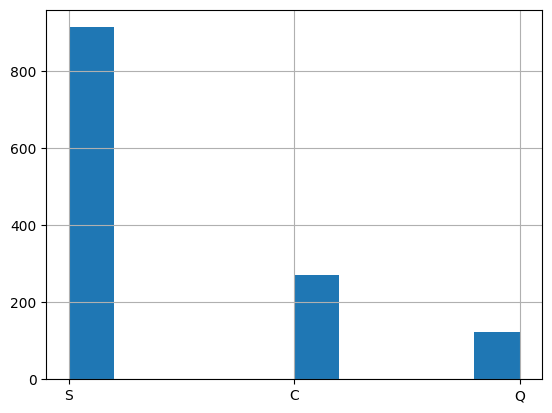

In [49]:
# finding the most common using histograms
titanic_df['embarked'].hist()

In [50]:
titanic_df["embarked"].fillna('S', inplace=True)

#### Assuming that if survival is not recorded, that passenger did not survive

In [51]:
titanic_df['survived'].fillna('0', inplace=True)

#### Seems to be more third class passengers, so if Na, we assume they are also third class

In [52]:
titanic_df['pclass'].fillna('3', inplace=True)

#### Seems to be more male than female, so we assume Na to be male

In [53]:
titanic_df['sex'].fillna('male', inplace=True)

#### Fill fare with average of the feature

In [54]:
titanic_df['fare'].fillna(titanic_df['fare'].mean().round(), inplace=True)

### Dealing with Sibsp and Parch

#### Based on the kaggle description of these two features,
#### they appear to be related to family travel
#### We can assume that a category appears: travelingalone
#### Inspired by: https://www.kaggle.com/code/mnassrib/titanic-logistic-regression-with-python#3.-Exploratory-Data-Analysis

In [55]:
titanic_df['travelalone']=np.where((titanic_df["sibsp"]+titanic_df["parch"])>0, 0, 1)

In [56]:
titanic_df.drop('sibsp', axis=1, inplace=True)
titanic_df.drop('parch', axis=1, inplace=True)

### Categorical to Numerical

In [57]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1310 entries, 0 to 1309
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pclass       1310 non-null   object 
 1   survived     1310 non-null   object 
 2   sex          1310 non-null   object 
 3   age          1310 non-null   float64
 4   fare         1310 non-null   float64
 5   embarked     1310 non-null   object 
 6   travelalone  1310 non-null   int64  
dtypes: float64(2), int64(1), object(4)
memory usage: 71.8+ KB


In [58]:
# survived
titanic_df["survived"] = titanic_df["survived"].astype('float')

In [59]:
# sex
def binarizer_sex(val):
    if val == 'female':
        return 0
    if val == 'male':
        return 1
titanic_df['sex'] = titanic_df['sex'].apply(binarizer_sex)

In [60]:
# embarked
def embarked_ordinator(val):
    if val == 'S':
        return 1
    if val == 'Q':
        return 2
    if val == 'C':
        return 3
titanic_df['embarked'] = titanic_df['embarked'].apply(embarked_ordinator)
titanic_df["embarked"] = titanic_df["embarked"].astype('float')

In [61]:
titanic_df.head()

,pclass,survived,sex,age,fare,embarked,travelalone
0,1.0,1.0,0,29.0000,211.3375,1.0,1
1,1.0,1.0,1,0.9167,151.5500,1.0,0
2,1.0,0.0,0,2.0000,151.5500,1.0,0
3,1.0,0.0,1,30.0000,151.5500,1.0,0
4,1.0,0.0,0,25.0000,151.5500,1.0,0


## Analysis

### Scaling and Splitting

In [62]:
# separate features from target
features = titanic_df.drop('survived', axis=1)
target = titanic_df['survived']

### Logistic Regression

In [63]:
lgr_X = features
lgr_y = target

# split data into training and test sets
lgr_X_train, lgr_X_test, lgr_y_train, lgr_y_test = train_test_split(lgr_X, lgr_y, random_state = 50, train_size = 0.7)

In [64]:
# scale features
scaler = StandardScaler()
lgr_X_train_scaled = scaler.fit_transform(lgr_X_train)
lgr_X_test_scaled = scaler.fit_transform(lgr_X_test)

#### newton-cg

In [65]:
lgr_newton = LogisticRegression(random_state=0, solver="newton-cg")

In [66]:
lgr_newton.fit(lgr_X_train_scaled, lgr_y_train)
lgr_newton_y_predict = lgr_newton.predict(lgr_X_test_scaled)

In [67]:
print(accuracy_score(lgr_y_test, lgr_newton_y_predict))
print(precision_score(lgr_y_test, lgr_newton_y_predict))

0.766497461928934
0.6560509554140127


#### lbfgs

In [68]:
lgr_lbfgs = LogisticRegression(random_state=0, solver="lbfgs")

In [69]:
lgr_lbfgs.fit(lgr_X_train_scaled, lgr_y_train)
lgr_lbfgs_y_predict = lgr_lbfgs.predict(lgr_X_test_scaled)

In [70]:
print(accuracy_score(lgr_y_test, lgr_lbfgs_y_predict))
print(precision_score(lgr_y_test, lgr_lbfgs_y_predict))

0.766497461928934
0.6560509554140127


#### sag

In [71]:
lgr_sag = LogisticRegression(random_state=0, solver="sag")

In [72]:
lgr_sag.fit(lgr_X_train_scaled, lgr_y_train)
lgr_sag_y_predict = lgr_sag.predict(lgr_X_test_scaled)

In [73]:

print(accuracy_score(lgr_y_test, lgr_sag_y_predict))
print(precision_score(lgr_y_test, lgr_sag_y_predict))

0.766497461928934
0.6560509554140127


#### saga

In [74]:
lgr_saga = LogisticRegression(random_state=0, solver="saga")

In [75]:
lgr_saga.fit(lgr_X_train_scaled, lgr_y_train)
lgr_saga_y_predict = lgr_saga.predict(lgr_X_test_scaled)

In [76]:
print(accuracy_score(lgr_y_test, lgr_saga_y_predict))
print(precision_score(lgr_y_test, lgr_saga_y_predict))

0.766497461928934
0.6560509554140127


## C Hyperparameter: saga

### C=0.001

In [77]:
lgr_saga = LogisticRegression(random_state=0, solver="saga", C=0.001)

In [78]:
lgr_saga.fit(lgr_X_train_scaled, lgr_y_train)
lgr_saga_y_predict = lgr_saga.predict(lgr_X_test_scaled)

In [79]:
print(accuracy_score(lgr_y_test, lgr_saga_y_predict))
print(precision_score(lgr_y_test, lgr_saga_y_predict))

0.7360406091370558
0.9512195121951219


### C=0.010

In [82]:
lgr_saga = LogisticRegression(random_state=0, solver="saga", C=0.010)

In [83]:
lgr_saga.fit(lgr_X_train_scaled, lgr_y_train)
lgr_saga_y_predict = lgr_saga.predict(lgr_X_test_scaled)

In [84]:
print(accuracy_score(lgr_y_test, lgr_saga_y_predict))
print(precision_score(lgr_y_test, lgr_saga_y_predict))

0.766497461928934
0.6762589928057554


### C=0.10

In [85]:
lgr_saga = LogisticRegression(random_state=0, solver="saga", C=0.10)

In [86]:
lgr_saga.fit(lgr_X_train_scaled, lgr_y_train)
lgr_saga_y_predict = lgr_saga.predict(lgr_X_test_scaled)

In [87]:
print(accuracy_score(lgr_y_test, lgr_saga_y_predict))
print(precision_score(lgr_y_test, lgr_saga_y_predict))

0.7690355329949239
0.6602564102564102


### C=0.00109

In [140]:
lgr_saga = LogisticRegression(random_state=0, solver="saga", C=0.00109)

In [141]:
lgr_saga.fit(lgr_X_train_scaled, lgr_y_train)
lgr_saga_y_predict = lgr_saga.predict(lgr_X_test_scaled)

In [142]:
print(accuracy_score(lgr_y_test, lgr_saga_y_predict))
print(precision_score(lgr_y_test, lgr_saga_y_predict))

0.733502538071066
0.9285714285714286


### C=0.019

In [134]:
lgr_saga = LogisticRegression(random_state=0, solver="saga", C=0.019)

In [135]:
lgr_saga.fit(lgr_X_train_scaled, lgr_y_train)
lgr_saga_y_predict = lgr_saga.predict(lgr_X_test_scaled)

In [136]:
print(accuracy_score(lgr_y_test, lgr_saga_y_predict))
print(precision_score(lgr_y_test, lgr_saga_y_predict))

0.7741116751269036
0.6805555555555556


## SVM

In [143]:
svm_X = features
svm_y = target

# split data into training and test sets
svm_X_train, svm_X_test, svm_y_train, svm_y_test = train_test_split(svm_X, svm_y, random_state = 50, train_size = 0.7)

In [144]:
# scale features
scaler = StandardScaler()
svm_X_train_scaled = scaler.fit_transform(svm_X_train)
svm_X_test_scaled = scaler.fit_transform(svm_X_test)

### C=1.0

In [149]:
svm = LinearSVC(C=1.0, max_iter=5000)

In [150]:
svm.fit(svm_X_train_scaled, svm_y_train)
svm_y_predict = svm.predict(svm_X_test_scaled)

In [151]:
print(accuracy_score(svm_y_test, svm_y_predict))
print(precision_score(svm_y_test, svm_y_predict))

0.7690355329949239
0.6644736842105263


### C=0.01

In [152]:
svm = LinearSVC(C=0.01, max_iter=5000)

In [153]:
svm.fit(svm_X_train_scaled, svm_y_train)
svm_y_predict = svm.predict(svm_X_test_scaled)

In [154]:
print(accuracy_score(svm_y_test, svm_y_predict))
print(precision_score(svm_y_test, svm_y_predict))

0.7715736040609137
0.6688741721854304


### C=0.0001

In [161]:
svm = LinearSVC(C=0.0001, max_iter=5000)

In [162]:
svm.fit(svm_X_train_scaled, svm_y_train)
svm_y_predict = svm.predict(svm_X_test_scaled)

In [163]:
print(accuracy_score(svm_y_test, svm_y_predict))
print(precision_score(svm_y_test, svm_y_predict))

0.7563451776649747
0.6510067114093959


### C=0.1

In [192]:
svm = LinearSVC(C=0.1, max_iter=5000)

In [193]:
svm.fit(svm_X_train_scaled, svm_y_train)
svm_y_predict = svm.predict(svm_X_test_scaled)

In [194]:
print(accuracy_score(svm_y_test, svm_y_predict))
print(precision_score(svm_y_test, svm_y_predict))

0.7690355329949239
0.6644736842105263


### C=0.001

In [217]:
svm = LinearSVC(C=0.001, max_iter=5000)

In [218]:
svm.fit(svm_X_train_scaled, svm_y_train)
svm_y_predict = svm.predict(svm_X_test_scaled)

In [219]:
print(accuracy_score(svm_y_test, svm_y_predict))
print(precision_score(svm_y_test, svm_y_predict))

0.766497461928934
0.6580645161290323
